# Plot a Spectral Signature

A spectral signature is a plot of the amount of light energy reflected by an object throughout the range of wavelengths in the electromagnetic spectrum. The spectral signature of an object conveys useful information about its structural and chemical composition. We can use these signatures to identify and classify different objects from a spectral image. 

For example, vegetation has a distinct spectral signature, as illustrated below:
<p>
<center><strong>Spectral Signature of Vegetation</strong></center>
<img src="./notebook_images/spectral_signature.png" style="width: 400px;"/>
</p>
Vegetation has a unique spectral signature characterized by high reflectance in the near infrared wavelengths, and much lower reflectance in the green portion of the visible spectrum. We can extract reflectance values in the NIR and visible spectrums from hyperspectral data in order to map vegetation on the earth's surface. You can also use spectral curves as a proxy for vegetation health. We will explore this concept more in the next lesson, where we will caluclate vegetation indices.  
<p><center><strong>Example spectra of water, green grass, dry grass, and soil<strong></center>
<img src="./notebook_images/reflectance_curves.png" style="width: 400px;"/>
<p>

## Objectives

In this exercise, we will learn how to extract and plot a spectral profile from a single pixel of a reflectance band in a NEON hyperspectral hdf5 file. To do this, we will use the `aop_h5refl2array` function to read in and clean our h5 reflectance data, and the Python package `pandas` to create a dataframe for the reflectance and associated wavelength data. Instead of copying and pasting each function like we did in the last lesson, we will import a module containing several functions. This imports the functions behind the scenes, the same way you import standard Python packages. In order to import a module, it must be located in the same directory as where you are running your noteook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
cd hyperspectral

/home/jovyan/NEON_workshop/tutorials/ipynb/hyperspectral


Import the hyperspectral functions into the variable `neon_hs` (for neon hyperspectral):

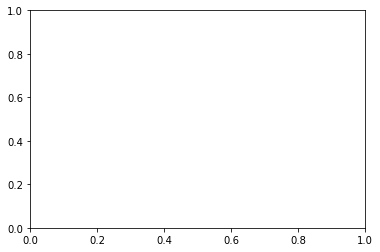

In [3]:
import neon_aop_hyperspectral as neon_hs

In [4]:
refl, metadata = neon_hs.aop_h5refl2array('../../../data/NEON_D16_MCRA_DP3_566300_4901000_reflectance.h5')

Optionally, you can view the data stored in the metadata dictionary, and print the minimum, maximum, and mean reflectance values in the tile. In order to handle any `nan` values, use the `Numpy` package (`np`) functions `nanmin` `nanmax` and `nanmean`. 

```python
for item in sorted(metadata):
    print(item + ':',metadata[item])

print('Tile Reflectance Stats:')
print('min:',np.nanmin(refl))
print('max:',round(np.nanmax(refl),2))
print('mean:',round(np.nanmean(refl),2))
```

For reference, plot the red band of the tile, using splicing, and the `plot_aop_refl` function:

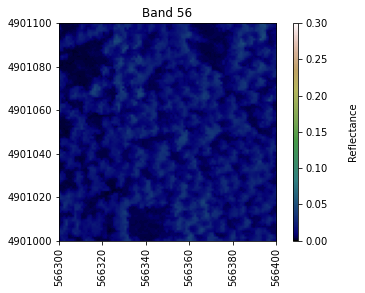

In [5]:
b56 = refl[:,:,55]

neon_hs.plot_aop_refl(b56,
                      metadata['spatial extent'],
                      colorlimit=(0,0.3),
                      title='Band 56',
                      cmap_title='Reflectance',
                      colormap='gist_earth')

We can use `pandas` to create a dataframe containing the wavelength and reflectance values for a single pixel - in this example, we'll look at the center pixel of the tile (500,500). 

To extract all reflectance values from a single pixel, use splicing as we did before to select a single band, but now we need to specify (y,x) and select all bands (using `:`).

In [6]:
pixel_df = pd.DataFrame()
pixel_df['reflectance'] = refl[50,50,:]
pixel_df['wavelengths'] = metadata['wavelength']

We can preview the first and last five values of the dataframe using `head` and `tail`:

In [7]:
print(pixel_df.head(5))
print(pixel_df.tail(5))

   reflectance  wavelengths
0       0.0279   381.375793
1       0.0335   386.385986
2       0.0284   391.396301
3       0.0284   396.406586
4       0.0238   401.416901
     reflectance  wavelengths
421       0.0127  2490.703125
422       0.0130  2495.713379
423       0.0055  2500.723633
424       0.0266  2505.733887
425       0.0000  2510.744141


We can now plot the spectra, stored in this dataframe structure. `pandas` has a built in plotting routine, which can be called by typing `.plot` at the end of the dataframe. 

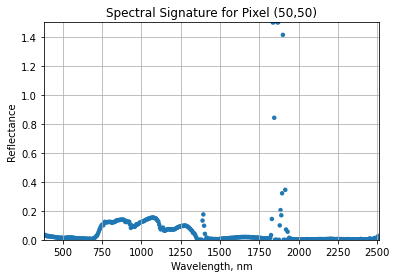

In [8]:
pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none')
plt.title('Spectral Signature for Pixel (50,50)')
ax = plt.gca() 
ax.set_xlim([np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths'])])
ax.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance'])])
ax.set_xlabel("Wavelength, nm")
ax.set_ylabel("Reflectance")
ax.grid('on')

##  Water Vapor Band Windows 
We can see from the spectral profile above that there are spikes in reflectance around ~1400nm and ~1800nm. These result from water vapor which absorbs light between wavelengths 1340-1445 nm and 1790-1955 nm. The atmospheric correction that converts radiance to reflectance subsequently results in a spike at these two bands. The wavelengths of these water vapor bands is stored in the reflectance attributes, which is saved in the reflectance metadata dictionary created with `aop_h5refl2array`: 

In [9]:
bbw1 = metadata['bad band window1']; 
bbw2 = metadata['bad band window2']; 
print('Bad Band Window 1:',bbw1)
print('Bad Band Window 2:',bbw2)

Bad Band Window 1: [1340 1445]
Bad Band Window 2: [1790 1955]


Below we repeat the plot we made above, but this time draw in the edges of the water vapor band windows that we need to remove. 

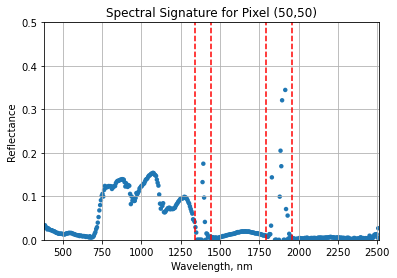

In [10]:
pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
plt.title('Spectral Signature for Pixel (50,50)')
ax1 = plt.gca(); ax1.grid('on')
ax1.set_xlim([np.min(pixel_df['wavelengths']),np.max(pixel_df['wavelengths'])]); 
ax1.set_ylim(0,0.5)
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")

#Add in red dotted lines to show boundaries of bad band windows:
ax1.plot((1340,1340),(0,1.5), 'r--')
ax1.plot((1445,1445),(0,1.5), 'r--')
ax1.plot((1790,1790),(0,1.5), 'r--')
ax1.plot((1955,1955),(0,1.5), 'r--')

We can now set these bad band windows to `nan`, along with the last 10 bands, which are also often noisy (as seen in the spectral profile plotted above). First make a copy of the wavelengths so that the original metadata doesn't change.

In [11]:
import copy
w = metadata['wavelength'].copy() #make a copy to deal with the mutable data type
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan #can also use bbw1[0] or bbw1[1] to avoid hard-coding in
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
#print(w) #optionally print wavelength values to show that -9999 values are replaced with nan

## DEMO: Interactive Spectra Visualization

Finally, we can create a `widget` to interactively view the spectra of different pixels along the reflectance tile. Run the two cells below, and interact with them to gain a better sense of what the spectra look like for different materials on the ground. 

In [12]:
#define index corresponding to nan values:
nan_ind = np.argwhere(np.isnan(w))

#define refl_band, refl, and metadata 
refl_band = b56

In [13]:
from ipywidgets import *

def spectraPlot(pixel_x,pixel_y):

    reflectance = refl[pixel_y,pixel_x,:]
    reflectance[nan_ind]=np.nan
    
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    # fig, axes = plt.subplots(nrows=1, ncols=2)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(metadata['wavelength']),np.max(metadata['wavelength'])]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=metadata['spatial extent'],clim=(0,0.1)); 
    plt.title('Pixel Location'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
    ax2.plot(metadata['spatial extent'][0]+pixel_x,metadata['spatial extent'][3]-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(metadata['spatial extent'][0],metadata['spatial extent'][1])
    ax2.set_ylim(metadata['spatial extent'][2],metadata['spatial extent'][3])
    
interact(spectraPlot, pixel_x = (0,refl.shape[1]-1,1),pixel_y=(0,refl.shape[0]-1,1));

interactive(children=(IntSlider(value=49, description='pixel_x', max=99), IntSlider(value=49, description='pix…